In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import json
import codecs
import folium
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
%matplotlib inline
#np.set_printoptions(threshold=np.nan)

### Load election data

In [2]:
def load_party_data(path):
    data=pd.read_excel(path)
    data.drop([data.columns[0],data.columns[2],data.columns[3],data.columns[4]],1,inplace=True)
    data.drop([0,1],0,inplace=True)
    data.columns=['commune','party','percentage']
    data=data.ffill()
    data=data.groupby(['commune','party']).sum().unstack('party')
    data2=data.reset_index()['percentage']
    data2['commune']=data.reset_index()['commune']
    return data2

In [3]:
#load party data
data=load_party_data('data/partis_12prem_vote_2015.xlsx')
data2=load_party_data('data/partis_12der_vote_2015.xlsx')

#take only commune (not districts)
data=data[data['commune'].str.startswith('......')]
data2=data2[data2['commune'].str.startswith('......')]
data['commune']=data['commune'].str[7:]
data2['commune']=data2['commune'].str[7:]

#merge the two datasets
data=pd.merge(data,data2,on='commune')

#replace non-available parties with 0
data.loc[:, data.columns != 'commune']=data.loc[:, data.columns != 'commune'].replace('...','0')

#remove data coming from correspondancy votes
data=data[(data['commune'].str[:2]==(data['commune'].str.upper()).str[:2]) & (data['commune'].str[2]=='-') ==False]
data.loc[:, data.columns != 'commune']=data.loc[:, data.columns != 'commune']
data=data.set_index('commune')
data.index=data.index.str.replace(re.escape(' (Urne commune)'),'')
data=data.astype(float)
data=data.sort_index()

In [4]:
#load election metadata and rename columns
general=pd.read_excel('data/general_2015.xlsx')
general=general[['Unnamed: 1','Unnamed: 9']]
general.drop([0,1],0,inplace=True)
general.columns=['commune','voters']

#take only the voter per commune (not districts) and remove data coming from correspondancy votes
general=general[general['commune'].str.startswith('......',na=False)]
general['commune']=general['commune'].str[7:]
general=general[(general['commune'].str[:2]==(general['commune'].str.upper()).str[:2]) & (general['commune'].str[2]=='-') ==False]
general['voters']=general['voters'].replace('...','0')
general['voters']=general['voters'].astype(int)
general=general.set_index('commune')
general=general.sort_index()

In [5]:
#prepare data for genetic algorithm
data2=data.drop([col for col, val in data.sum().iteritems() if val==0],axis=1)
data_tot=data2.as_matrix()
data.index.to_series()[data_tot.sum(1)==0]

#remove communes with no votes
commune_with_no_vote=(data_tot.sum(1)==0)
data_tot[commune_with_no_vote==False]=np.divide(data_tot[commune_with_no_vote==False],data_tot[commune_with_no_vote==False].sum(1)[:,None])
data_tab=data_tot[commune_with_no_vote==False]

In [6]:
#prepare voter data for genetic algorithm
pop_tot=np.squeeze(general.as_matrix())
pop_tab=pop_tot[commune_with_no_vote==False]

In [7]:
#We defined here a list of merged communes between 2013 and 2015, with the resulting commune in the first position


fusion=[['Valbirse','Malleray','Bévilard','Pontenet'],
        ['Terre di Pedemonte','Cavigliano','Tegna','Verscio'],
        ['Val-de-Charmey','Charmey','Cerniat (FR)'],
        ['Sauge','Frinvillier','Plagne','Vauffelin'],
        ['Buchegg','Aetigkofen','Aetingen','Bibern (SO)','Brügglen','Gossliwil','Hessigkofen','Küttigkofen','Kyburg-Buchegg','Mühledorf (SO)','Tscheppach'],
        ['Domleschg','Almens','Paspels','Pratval','Rodels','Tomils'],
        ['Petit-Val','Châtelat','Monible','Sornetan','Souboz'],
        ['Ilanz/Glion','Castrisch','Ilanz','Ladir','Luven','Pitasch','Riein','Ruschein','Schnaus','Sevgein','Duvin','Pigniu','Rueun','Siat'],
        ['Péry-La Heutte','Péry','La Heutte'],
        ['Calanca','Arvigo','Braggio','Cauco','Selma'],
        ['Bettmeralp','Betten','Martisberg'],
        ['Arzier-Le Muids','Arzier'],
        ['Schinznach','Schinznach-Dorf','Oberflachs'],
        ['Albula/Alvra','Alvaschein','Mon','Stierva','Tiefencastel','Alvaneu','Brienz/Brinzauls','Surava'],
        ['Bussigny','Bussigny-près-Lausanne'],
        ['Stocken-Höfen','Niederstocken','Oberstocken','Höfen'],
        ['Plateau de Diesse','Diesse','Lamboing','Prêles'],
        ['Mendrisio','Besazio','Ligornetto','Meride'],
        ['Lugano','Bogno','Cadro','Carona','Certara','Cimadera','Sonvico','Valcolla'],
        ['Bauma','Sternenberg'],
        ['Scuol','Guarda','Ardez','Tarasp','Ftan','Sent'],
        ['Jegenstorf','Scheunen','Münchringen'],
        ['Fraubrunnen','Büren zum Hof','Etzelkofen','Grafenried','Limpach','Mülchi','Schalunen','Zauggenried'],
        ['Murten','Staatswald Galm'],
        ['Grafschaft','Kommunanz Reckingen-Gluringen/Grafschaft'],
        ['Cadenazzo','Comunanza Cadenazzo/Monteceneri'],
        ['Wiesendangen','Bertschikon'],
        ['Innertkirchen','Gadmen'],
        ['Endingen','Unterendingen'],
        ['Uttigen','Kienersrüti'],
        ['Bremgarten (AG)','Bremgarten','Hermetschwil-Staffeln'],
        ['Zernez','Lavin','Susch'],
        ['Oberdiessbach','Bleiken bei Oberdiessbach'],
        ['Vals','St. Martin']
]

### Visualize election results :

In [8]:
# read topojson data
json_data_gemeinden = json.load(codecs.open('data/gemeinden.topo.json', 'r', 'utf-8-sig'))
json_data_kantone = json.load(codecs.open('data/kantone.topo.json', 'r', 'utf-8-sig'))

In [9]:
#since the topojson for visualisation dates back to 2013, some old municipipalities in the topojson now unified are
#missing in the dataset. Since it's complicated to find a topojson up to date, we will duplicate the data from the 
#unified municipalities to the old ones.

#list of the old munipalities fron the topjson
with open('data/gemeinden.topo.json') as f:
    muni=json.load(f)
    
s= pd.DataFrame(muni['objects']['gemeinden']['geometries'])
properties=s['properties'].values
municipalities_topo = pd.DataFrame(list(properties))['GMDNAME']
#municipalities_topo

#list of the new municipalities from dataset
#municipalities_data=data['commune']
municipalities_data = pd.Series(data.index.values)
municipalities_data.head()

#diff of both: municipalities in top no it dataset
diff_ind=~municipalities_topo.isin(municipalities_data) 
municipalities_diff= municipalities_topo[diff_ind]

#for all diff munip create new row in data:
#diff_df=pd.DataFrame(columns = data.columns, index= municipalities_diff)
for old_munip in municipalities_diff:
    #find corresponding new munip
    for i in fusion:
        for j in i:
            if old_munip == j:
                new_munip=i[0]
                #copy row from data with corresponding to new munip
                new_row=data.ix[new_munip]
                new_row = pd.DataFrame(new_row.rename(old_munip)).T
                data=data.append(new_row)


/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [10]:
# display only borders
center_coord = [46.8011111,8.2266667]
m_swiss = folium.Map(location=center_coord,
            tiles='cartodbpositron',           
            zoom_start=7.5)

folium.TopoJson(json_data_gemeinden,'objects.gemeinden',name='communes',style_function=lambda feature: {
        'color': 'blue',
        'fillOpacity':0.0,
        'weight': 2}).add_to(m_swiss)

folium.TopoJson(json_data_kantone,'objects.kantone',name='cantons',style_function=lambda feature: {
        'color': 'red',
        'fillOpacity':0.0,
        'weight': 2}).add_to(m_swiss)
folium.LayerControl().add_to(m_swiss)
#m_swiss

Visualise the [map](https://kbacsa.github.io/swiss_border.html).

In [11]:
# choose party to display
party = 'SVP/UDC'

# get election results for selected party
n_communes = len(json_data_gemeinden['objects']['gemeinden']['geometries'])
party_values = []

for i in range(n_communes):
    json_name = json_data_gemeinden['objects']['gemeinden']['geometries'][i]['properties']['GMDNAME']
    dfval = data[data.index==json_name][party].values.tolist()
    if not dfval:
        dfval=[0]  
    party_values.append([json_name,dfval[0]])
    
labels = ['Name','Score']
party_df = pd.DataFrame(data=party_values,columns=labels)

In [12]:
# build and display folium map of election results
center_coord = [46.8011111,8.2266667]
m_swiss = folium.Map(location=center_coord,
            tiles='cartodbpositron',           
            zoom_start=7.5)

serie = party_df.set_index('Name')['Score']

scale = list(np.linspace(0.,serie.max(),6))

m_swiss.choropleth(geo_data=json_data_gemeinden, topojson='objects.gemeinden', 
    data=serie,
    key_on='feature.properties.GMDNAME',
    threshold_scale=scale,
    fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.3,
    highlight = True)

folium.TopoJson(json_data_kantone,'objects.kantone',name='cantons',style_function=lambda feature: {
        'color': 'blue',
        'fillOpacity':0.0,
        'weight': 2}).add_to(m_swiss)

#m_swiss

Visualise the [map](https://kbacsa.github.io/swiss_votes_SVP_2015.html).

### Spectral clustering

In [13]:
# drop parties with no votes
data.drop([col for col, val in data.sum().iteritems() if val==0],axis=1)
features = pd.DataFrame(data)

In order to calculate our distance map, we will use the L1-norm. Similarly to signal processing, the L1-norm enables us to embed a "sharpness" property when partitioning our graph, rather than the L2-norm (euclidean) which has a tendancy to smoothen out divisions instead.

In [14]:
# construct adjacency map based on L1-norm distance map with gaussian kernel
distances = spatial.distance.squareform(spatial.distance.pdist(features,'minkowski', p=1.))
kernel_width = distances.mean()
weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
np.fill_diagonal(weights,0)

In [15]:
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);

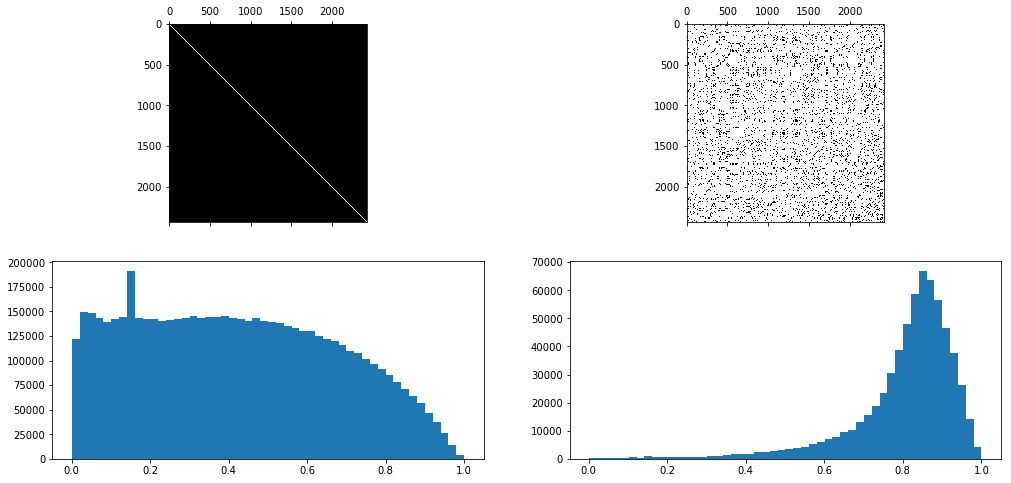

In [16]:
# sparsify weights matrix using nearest neighbors
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
plot(weights, axes[:, 0])

NEIGHBORS = 350

for i in range(weights.shape[0]):
    idx = weights[i,:].argsort()[:-NEIGHBORS]
    weights[i,idx] = 0
    weights[idx,i] = 0

plot(weights, axes[:, 1])

We can see that the weights of our nodes exhibit a power tail distribution. This indicates that our graph is not random, and that it can instead be clustered into different classes. 

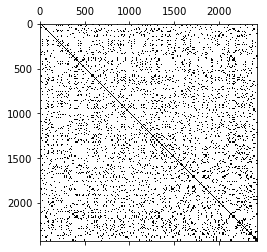

In [17]:
# compute normalized laplacian
degrees = np.sum(weights,axis=0)
laplacian = np.diag(degrees**-0.5) @ (np.diag(degrees) - weights) @ np.diag(degrees**-0.5)
plt.spy(laplacian);
laplacian = sparse.csr_matrix(laplacian)

In [18]:
# calculate eigenvectors (features)
eigenvalues, eigenvectors = sparse.linalg.eigsh(A=laplacian,k=10,which='SM')

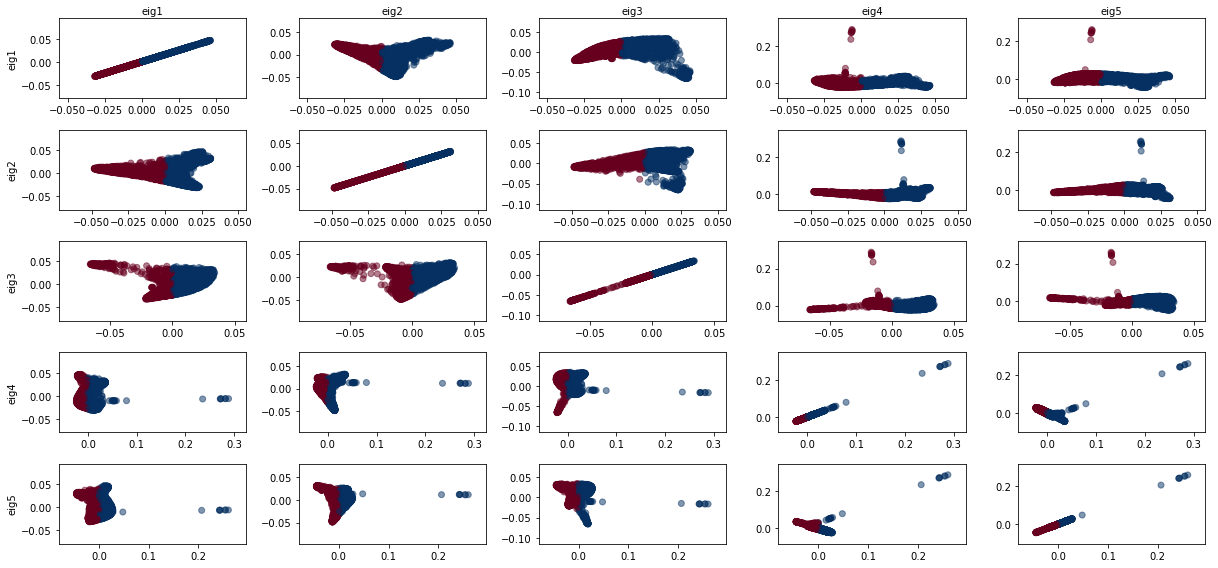

In [19]:
fix, axes = plt.subplots(nrows=5, ncols=5, figsize=(17, 8))
for i in range(1,6):
    for j in range(1,6):
        if i == 1:
            axes[i-1,j-1].set_xlabel('eig' + str(j))
            axes[i-1,j-1].xaxis.set_label_position('top') 
        if j == 1:
            axes[i-1,j-1].set_ylabel('eig' + str(i))
        x = eigenvectors[:,i]
        y = eigenvectors[:,j]
        labels = np.sign(x)
        axes[i-1,j-1].scatter(x, y, c=labels, cmap='RdBu', alpha=0.5)
        
fix.tight_layout()

In [20]:
# define classes and labels
class_1 = (eigenvectors[:,1] >= 0).astype(int)
class_2 = (eigenvectors[:,2] >= 0).astype(int)
class_3 = (eigenvectors[:,3] >= 0).astype(int)
labels = class_1 * 2**2 + class_2 * 2 + class_3
series = pd.Series(labels, index=data.index.values)

In [21]:
# plot classes
center_coord = [46.8011111,8.2266667]
m_swiss = folium.Map(location=center_coord,
            tiles='cartodbpositron',           
            zoom_start=7.5)

scale = list(np.linspace(0.,series.max(),6))

m_swiss.choropleth(geo_data=json_data_gemeinden, topojson='objects.gemeinden', 
    data=series,
    key_on='feature.properties.GMDNAME',
    threshold_scale=scale,
    fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.3,
    highlight = True)

folium.TopoJson(json_data_kantone,'objects.kantone',name='cantons',style_function=lambda feature: {
        'color': 'blue',
        'fillOpacity':0.0,
        'weight': 2}).add_to(m_swiss)

#m_swiss


Visualise the [map](https://kbacsa.github.io/spectral_clustering.html).

### Genetic algorithm

In [22]:
# crete_random_data(N=number of parties,M=number of communes)
# for each commune, create a random percentage distribution for the list of parties

def create_random_data(N,M):
    ptab = 2 * np.random.rand(N)
    tab = ptab[:,np.newaxis] + np.random.normal(0.0,0.5,(N,M))
    #tab = 1 * np.random.rand(N, M)
    tab = np.exp(tab)
    stab = np.sum(tab, 0)
    tab = tab / stab[None, :]
    return tab

#create_random_pop(M=number of communes)
#for each commune create a random population

def create_random_pop(M):
    #pop = np.random.randint(1000,size=M)
    pop = np.floor((np.random.pareto(1, size=M))*500)
    return pop

#vote(data=table with the percentage of each party for each canton,Nrepr=number of represent to elec for each canton)
#compute the vote to get the number of representants per cantons (check the highest percentage give it a representant,
#substract 1/Nrepr and repeat).

def vote(data,Nrepr):
    repr=np.zeros(data.shape)
    for i in range(Nrepr):
        maxi=np.argmax(data,0)

        k = (maxi[:,None]==np.arange(data.shape[0])).transpose()
        repr = repr + k.astype(int)
        data[k]=data[k]-(1/Nrepr)

    nan_tab = np.isnan(data)
    repr[nan_tab]=0

    return repr

#compute_tab_K(tab=percentage of vote by parties and commune,pop=population of each commune,K_index=canton of each commune)
#aggregate the vote per cantons

def compute_tab_K(tab,pop,K_index,K):
    K_full = (K_index[:, None] == np.arange(K))
    tab_mult_by_pop = pop * tab
    tab_sum = np.matmul(tab_mult_by_pop, K_full.astype(float))
    K_sum = (pop * K_full.transpose()).sum(1)

    final_tab = tab_sum/K_sum
    #nan_tab = np.isnan(final_tab)
    #final_tab[nan_tab]=0

    return final_tab

#reproduce(K_index1=canton for each commune (one repartition),K_index1=canton for each commune (another repartition))
#create a new repartition given two (select randomly one element in each repartition)

def reproduce_K(K_index1,K_index2):
    choice=np.random.randint(2,size=K_index1.shape)
    K_tot=np.stack([K_index1,K_index2],axis=1)
    return(K_tot[choice[:,None]==np.arange(2)])

#mute(K_index=canton per commune (one repartition),prob=probability to mute)
#change to a commune to a random canton with probability prob

def mute_K(K_index,K,prob):
    choice=np.random.randint(K,size=K_index.shape)
    change=(np.random.rand(K_index.shape[0])<prob).astype(int)
    K_tot = np.stack([K_index, choice], axis=1);
    return (K_tot[change[:,None]==np.arange(2)])

#get_new_generation(K_index_list=list of repartition,N_parents=number of parents,
#                   N_child_per_couple=number of generated children for two parents,
#                   prob=mute probability,K=number of canton)
#given a list of parent distribution, compute N_child_per_couple*N_parents"(N_parents-1) new distributions

def get_new_generation(K_index_list,N_parents,N_child_per_couple,prob,K):

    child_list=[]

    for i in range(N_parents):
        for j in range(i+1,N_parents):
            for k in range(N_child_per_couple):
                child=reproduce_K(K_index_list[i],K_index_list[j])
                child=mute_K(child,K,prob)
                child_list.append(child)
    return child_list

#compute_loss(child_list=a list of distribution,tab=percentage for each party for each commune, pop=population for each commune,
#             N_repr=number of representat per canton)
#compute the loss (difference between real opinion and represented opinion, can add other terms)

def compute_loss(child_list,tab,pop,N_repr):
    loss=[]
    rloss=[]
    for child in child_list:
        repr=vote(compute_tab_K(tab,pop,child,K),N_repr)
        repr_percent=(repr/(repr.sum().sum())).sum(1)
        rloss.append(np.square(repr_percent-ground_truth).sum())
        loss.append(np.square(repr_percent-ground_truth).sum()) 
    return loss, rloss


In [23]:
#=============== variable generation parameters ===============
N=15 #number of categories (parties)
M=2200 #number of item (communes)
#==============================================================

#=============== model parameters =============================
K=26 #number of cantons
N_repr=2 #number of representant per canton
#==============================================================

#=============== optimization parameters =============
N_parents=10
N_iter=1000
child_per_couple=2
mute_probability=0.04
#=====================================================

In [24]:
#=============== model parameters =============================
K=2 #number of cantons
N_repr=2 #number of representant per canton
#==============================================================

#=============== optimization parameters =============
N_parents=15
N_iter=100
child_per_couple=2
mute_probability=0.005
#=====================================================

#compute the global political opinion
ground_truth = (pop_tab * np.transpose(data_tab)).sum(1)/pop_tab.sum()
#initailize parent list
parent_list = []
for i in range(N_parents):
    parent_list.append(np.random.randint(K,size=pop_tab.shape[0]))

minloss=[]
avgloss=[]

minrloss=[]
avgrloss=[]
#perform optimization
for iter in range(N_iter):
    child_list = get_new_generation(parent_list,N_parents,child_per_couple,mute_probability,K)
    
    loss,rloss = compute_loss(child_list,np.transpose(data_tab),pop_tab,N_repr)
    loss=np.array(loss)
    rloss=np.array(rloss)
    minloss.append(loss.min())
    avgloss.append(loss.mean())
    minrloss.append(rloss.min())
    avgrloss.append(rloss.mean())
    
    idx = loss.argsort()[:N_parents]
    parent_list=[child_list[i] for i in idx]

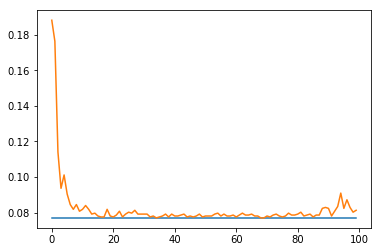

In [25]:
#display loss
plt.plot(np.arange(0,N_iter,1),np.array(minrloss))
plt.plot(np.arange(0,N_iter,1),np.array(avgrloss))

### Get graph


/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


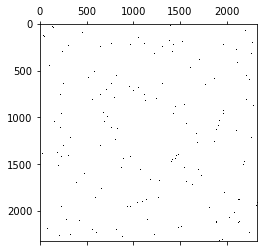

In [26]:
#load the data output from get_neighbors
graph_data=pd.read_csv('graph_commune.csv')
graph_data['municipality']
graph_data.columns=['index','neighbors indexes','municipality','neighbors']
fusion2=fusion
graph_data2=graph_data

#replace with the name of the merged communes
for elem in fusion:
    graph_data2['municipality'][graph_data['municipality'].isin(elem[1:])]=elem[0]
#check the differences
common=pd.Series(list(set(data.index).intersection(set(graph_data2['municipality']))))
diff1=pd.Series(list(set(data.index)-set(common)))
diff2=pd.Series(list(set(graph_data2['municipality'])-set(common)))
#set the remaining territories as lakes
graph_data2['municipality'][graph_data['municipality'].isin(diff2)]='lac'
fusion2.append(list(diff2))
fusion2[-1].insert(0,'lac')

#extracting the list of adjacent communes (string in the data)
adjacency_list=[]
for com in graph_data2['neighbors']:
    j=re.findall('"(.*?)"[ \n\]]',com)
    k=re.findall('\'(.*?)\'[ \n\]]',com)
    k=[ (x.split('\'', 1)[1] if "\'" in x else x)for x in k ]
    adjacency_list.append(k + j)

#replace the name in the adjacent commune by the merged names
for elem in fusion2:
    for i,nei in enumerate(adjacency_list):
        nei2=pd.Series(nei)
        nei2[nei2.isin(elem[1:])]=elem[0]
        adjacency_list[i]=list(nei2)

#remove duplicates in adjacent communes
for i,nei in enumerate(adjacency_list):
    adjacency_list[i]=list(set(nei))

#merge adjacent communes
commune_list=list(set(graph_data2['municipality']))
commune_list=list(pd.Series(commune_list).sort_values())
adjacency_list_true=([[]]*len(commune_list))
for i,elem in enumerate(commune_list):
    for j,comm in enumerate(graph_data2['municipality']):
        if elem==comm:
            adjacency_list_true[i]=list(set(adjacency_list_true[i]).union(set(adjacency_list[j])))

#set index instead of names
adjacency_list_index=[]
for i,elem in enumerate(commune_list):
    h_list=[]
    for adj_elem in adjacency_list_true[i]:
        h_list.append(commune_list.index(adj_elem))
    adjacency_list_index.append(h_list)

#define graph
N_comm=int(len(commune_list))
adjacency_matrix=np.zeros((N_comm,N_comm))
for i,elem in enumerate(commune_list):
    for adj_elem in adjacency_list_index[i]:
        b = np.zeros(N_comm)
        b[ adj_elem ] = 1
        adjacency_matrix[i,:]=adjacency_matrix[i,:]+b

plt.spy(adjacency_matrix)